# 2nd-order acoustic with 1D extrapolations

Schism is capable of implementing immersed boundaries based on 1D approximations of boundary conditions in the style of Mulder 2017. The process of doing so is similar to that detailed previously, albeit with some minor differences.

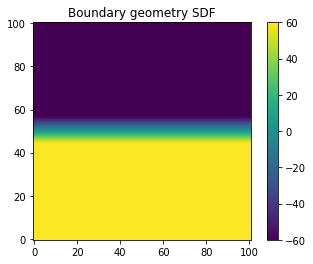

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the flat 2D sdf
sdf = read_sdf('horizontal', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

As before, we construct a `BoundaryGeometry` object.

In [2]:
from schism import BoundaryGeometry

bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


And again, define a `TimeFunction` for pressure.

In [3]:
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o, time_order=2)

Now we define the boundary conditions. As we want to use 1D extrapolations to impose the immersed boundary, we will need to supply 1D approximations of the 2D boundary conditions. Note that Schism is capable of separating boundary conditions pertaining to different extrapolations from one another.

In [4]:
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),  # Zero pressure on free surface
           dv.Eq(p.dy2, 0),  # Zero second derivative
           dv.Eq(p.dy4, 0)]  # Zero fourth derivative

bcs = BoundaryConditions(bc_list)

Now we assemble our `Boundary`. However, to use 1D approximations, we need to supply some additional keyword arguments. The first of these is `has_1D_basis=True`, and it is also advisable to set `strategy='reduce'`. The latter of these changes the strategy used when insufficient information is available for extrapolation. Instead of expanding the stencil, the order of the extrapolation is reduced.

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg, has_1D_basis=True, strategy='reduce')

As before, we get the substitution for the `p.dy2` expression.

In [6]:
deriv = (p.dy2,)
subs = boundary.substitutions(deriv)

Once again, before using this, we will set up a damping mask.

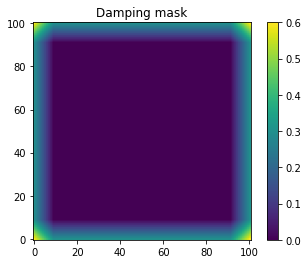

In [7]:
import numpy as np

damp = dv.Function(name='damp', grid=grid)

# Number of boundary layers
nbl = 10
taper = np.linspace(0, 0.3, nbl)

# Add the taper to the function's data
damp.data[:10] += taper[::-1, np.newaxis]
damp.data[-10:] += taper[:, np.newaxis]
damp.data[:, :10] += taper[np.newaxis, ::-1]
damp.data[:, -10:] += taper[np.newaxis, :]

plt.imshow(damp.data.T, origin='lower')
plt.title("Damping mask")
plt.colorbar()
plt.show()

We will also setup the source term.

In [8]:
from examples.seismic import TimeAxis, RickerSource

c = 1

t0 = 0.  # Simulation starts a t=0
tn = 550.  # Simulation last 0.55 seconds (550 ms)
dt = 0.5*10/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions
src.coordinates.data[0, :] = np.array(grid.extent) * .5
src.coordinates.data[0, -1] = 250.  # 250m above bottom

Now we can specify our wave equation, set up our source term, create the operator, and run it.

In [9]:
eq = dv.Eq(p.forward, 2*p-p.backward+dt**2*c**2*(p.dx2+subs[p.dy2])+damp*p.dt)

src_term = src.inject(field=p.forward, expr=c*src*dt**2)

op = dv.Operator([eq] + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0026380000000000015, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=1.4000000000000003e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

And finally plot the result.

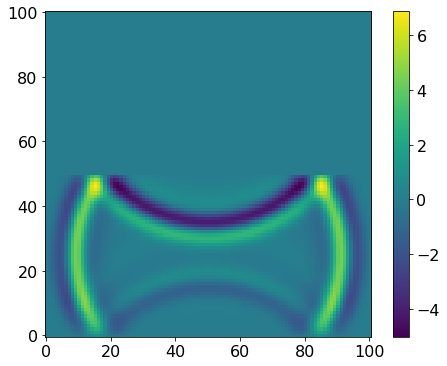

In [10]:
plt.imshow(p.data[1].T, origin='lower')
plt.colorbar()
plt.show()

This approach also yields the expected reflection.